# How to NanoDRT: Fitting DRT Spectrum to Ed's Data

One method of analysing Impedence Data for a range of different frequencies is by determining the DRT spectrum from a given measurement. However, determining such a spectrum is an ill posed problem and difficult to do. Several different methods of extracting the DRT spectrum have been demonstrated, including Ridge Regression, Bayesian Inference, Guassian Processing and Deep Learning Techniques. However, none have provided an easy to use Python package where users have the ability to fit their data in a variety of different ways. 

Here we demonstrate the beginnings of such a platform. 
This notebook demonstrates how we fit to both experimental and simulated data using Ridge Regression. 

## 1. Fitting to the Single ZARC Model


To begin we first use Ridge Regression to fit to the Single ZARC Model.

In [1]:
from nanodrt.drt_solver.drt import DRT
from nanodrt.fitting.optimizer import Optimizer
from nanodrt.drt_solver.measurements import ImpedenceMeasurement
from nanodrt.drt_solver.utils import (ZARC, 
                                 gamma_ZARC)
from nanodrt.plotting.plots import Plot

import jax.numpy as jnp 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Upload the Data and create a Measurement Object 

#columns = ["f", "Z_re", "Z_im"]
df = pd.read_csv("data/single_ZARC.csv")

f = df["f"].values
tau = 1./(2*jnp.pi*f)
# tau = jnp.flip(jnp.logspace(-4, 4, 500))

Z_exact_re =  df["Z_re"].values # can we do all this inside the measurement?
Z_exact_im =  df["Z_im"].values

# Create our measurement object
measurement = ImpedenceMeasurement(Z_exact_re, Z_exact_im, f)

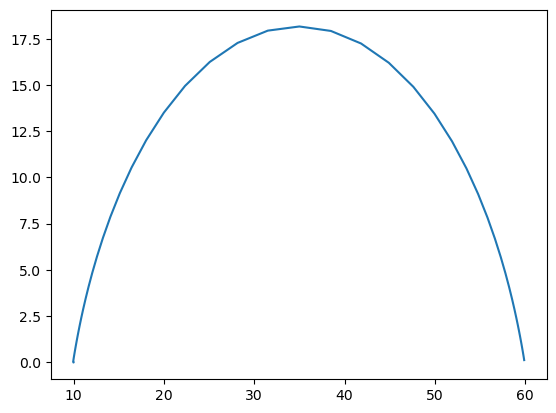

In [3]:
plt.plot(Z_exact_re, -Z_exact_im)
plt.show()

We wish to determine the DRT Spectrum of this measurement. To do this we require an initial guess. Here we will assume a Guassian fit for the DRT Spectrum. 

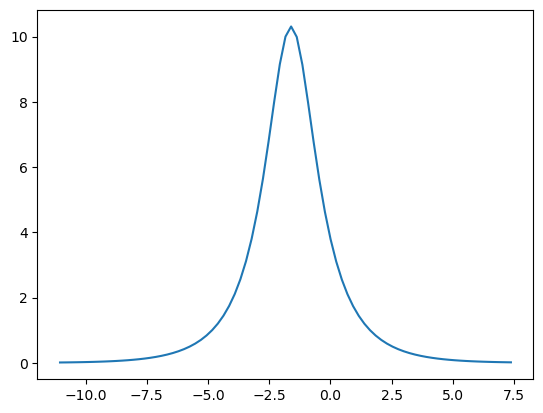

In [4]:
gamma_guess = gamma_ZARC(tau, R_ct=33, tau_0=.2, phi= .7)
plt.plot(jnp.log(tau), gamma_guess)
plt.show()

Following our initial guess we now create a DRT object which will contain all the information of the DRT spectrum. This will then be passed to a Optimisation Object and be used to store information in the optimisation process. 

In [5]:
drt = DRT(R_inf= 10, L_0=0, gamma=gamma_guess, tau=tau)

We now build our optimiser. Note that currently only the method 'regression' is implemented for fitting. However in the future, more methods shall be implemented. When determining the DRT spectrum we also note two methods of integration are currently available 'trapezoid' and 'rbf', which determine the integrals using the trapezoidal rule and the RBF discretisation methods respectively.

In [6]:
solver_dict = {"init_lbd": 0.05, "lbd_selection": "GCV", 'maxiter': 5e3}
optim = Optimizer(drt=drt, measurement=measurement, solver="regression", integration_method="rbf", solver_dict = solver_dict, rbf_function="guassian")
final_sim = optim.run()
print(final_sim.value)

0.2665279132208111


The optimisation has returned a FittedSpectrum object, which can now be used to plot and analyse the impedence data. 

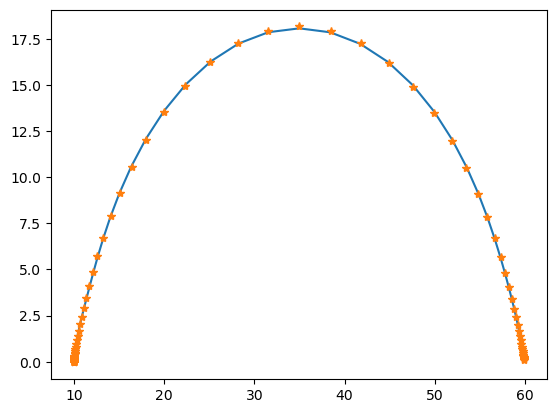

In [7]:
Z_re_fitted, Z_im_fitted = final_sim.simulate()
plt.plot(Z_re_fitted, -Z_im_fitted)
plt.plot(Z_exact_re, -Z_exact_im, '*')

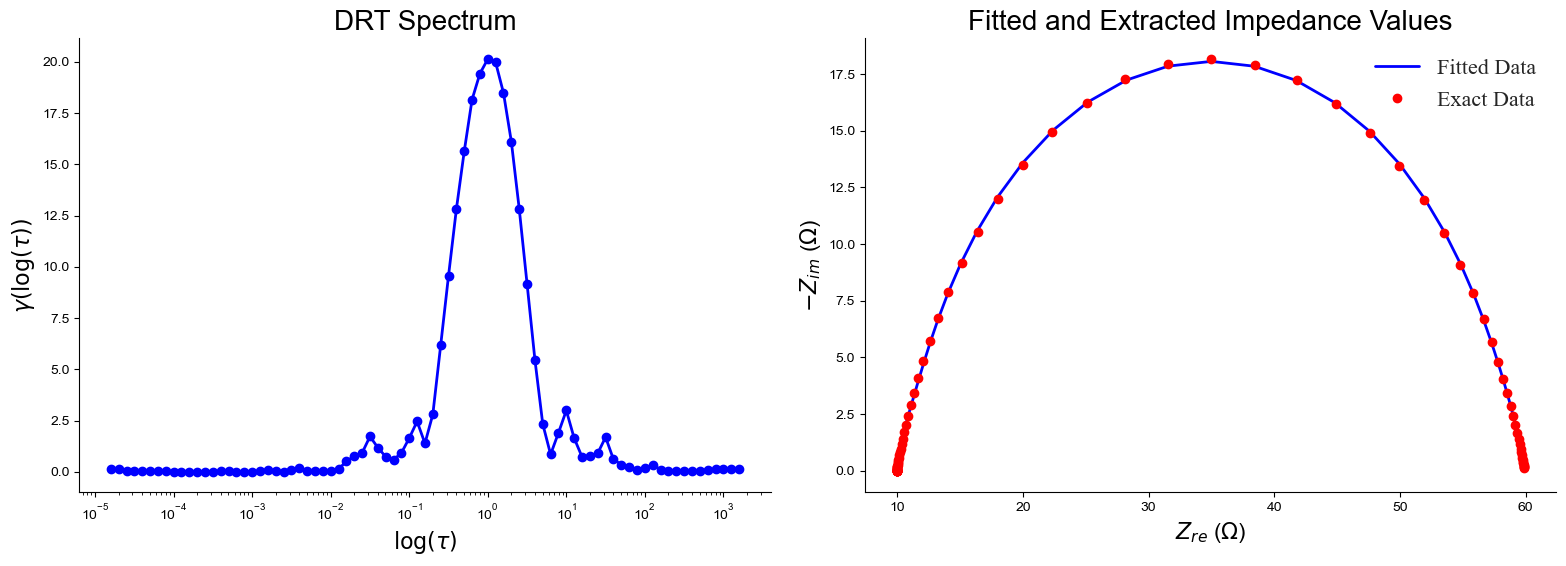

In [8]:

plot = Plot(final_sim, measurement)
plot.show()

## 1. Fitting to the Double ZARC Model

Now we repeat the same method for the Double ZARC model. To spice things up a bit, let's use the trapezoidal rule in the optimisation process. 


In [9]:
columns = ["f", "Z_re", "Z_im"]
df = pd.read_csv("data/double_ZARC.csv",)

f = jnp.array(df["f"].values)
tau = 1./(2*jnp.pi*f)
#tau = jnp.flip(jnp.logspace(-4, 4, 500))

Z_exact_re =  jnp.array(df["Z_re"].values)
Z_exact_im =  jnp.array(df["Z_im"].values)

# Create our measurement object
measurement = ImpedenceMeasurement(Z_exact_re, Z_exact_im, f)

In [10]:
drt = DRT(R_inf= 10, L_0=0, gamma=gamma_guess, tau=tau)
solver_dict = {'init_lbd': -3., 'lbd_selection': "GCV", 'maxiter': 5e3}
optim = Optimizer(drt=drt, measurement=measurement, solver="regression", rbf_function="guassian", integration_method="trapezoid", solver_dict = solver_dict)
final_sim = optim.run()


[1.59154943e+03 1.26421265e+03 1.00419980e+03 7.97664256e+02
 6.33607241e+02 5.03292121e+02 3.99779142e+02 3.17555860e+02
 2.52243586e+02 2.00364202e+02 1.59154943e+02 1.26421265e+02
 1.00419980e+02 7.97664256e+01 6.33607241e+01 5.03292121e+01
 3.99779142e+01 3.17555860e+01 2.52243586e+01 2.00364202e+01
 1.59154943e+01 1.26421265e+01 1.00419980e+01 7.97664256e+00
 6.33607241e+00 5.03292121e+00 3.99779142e+00 3.17555860e+00
 2.52243586e+00 2.00364202e+00 1.59154943e+00 1.26421265e+00
 1.00419980e+00 7.97664256e-01 6.33607241e-01 5.03292121e-01
 3.99779142e-01 3.17555860e-01 2.52243586e-01 2.00364202e-01
 1.59154943e-01 1.26421265e-01 1.00419980e-01 7.97664256e-02
 6.33607241e-02 5.03292121e-02 3.99779142e-02 3.17555860e-02
 2.52243586e-02 2.00364202e-02 1.59154943e-02 1.26421265e-02
 1.00419980e-02 7.97664256e-03 6.33607241e-03 5.03292121e-03
 3.99779142e-03 3.17555860e-03 2.52243586e-03 2.00364202e-03
 1.59154943e-03 1.26421265e-03 1.00419980e-03 7.97664256e-04
 6.33607241e-04 5.032921

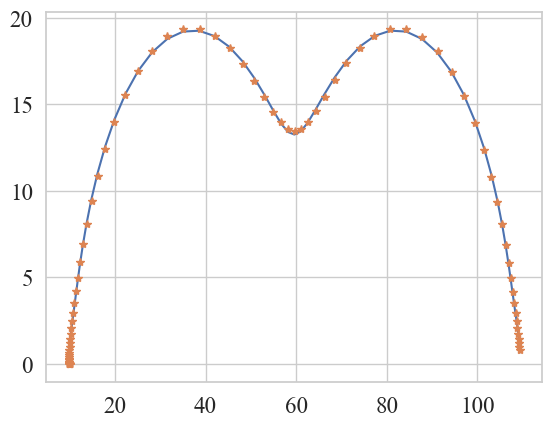

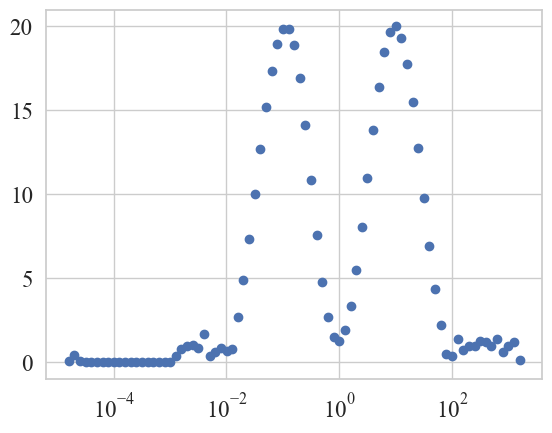

In [11]:
Z_re_fitted, Z_im_fitted = final_sim.simulate()
plt.plot(Z_re_fitted, -Z_im_fitted)
plt.plot(Z_exact_re, -Z_exact_im, '*')
plt.show()

plt.plot(final_sim.tau, final_sim.gamma, 'o')
plt.xscale("log")
plt.show()

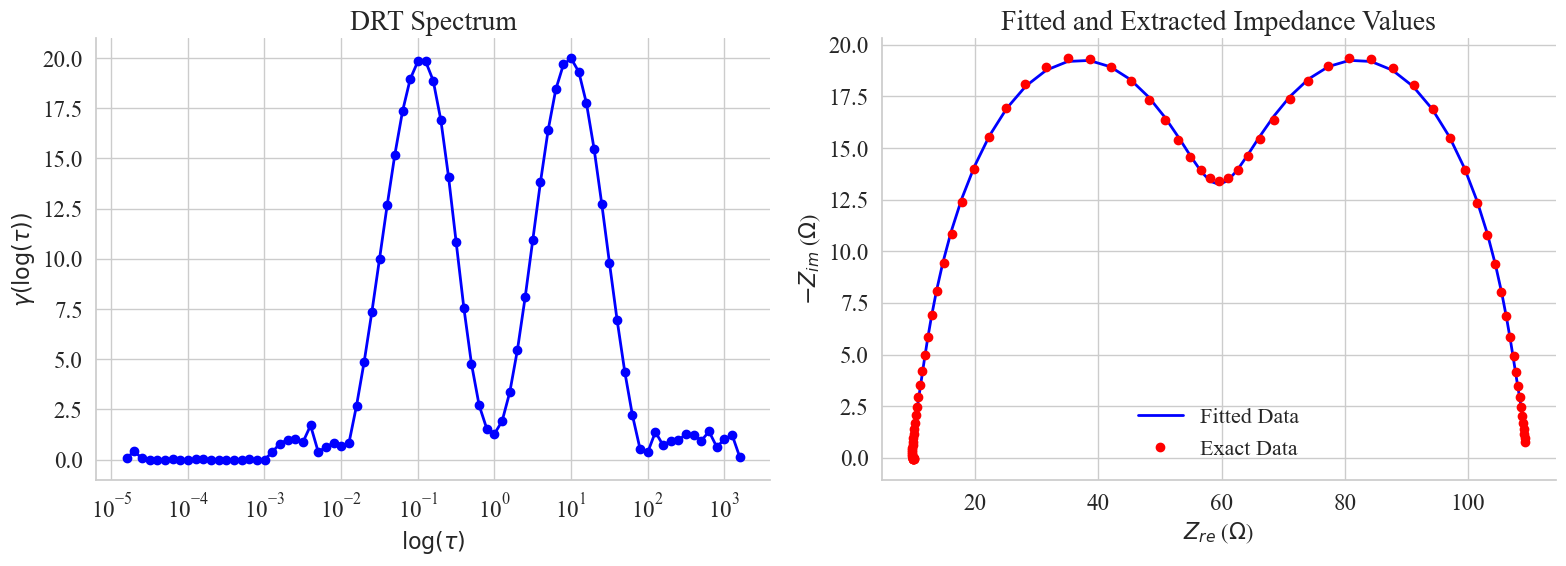

In [12]:

plot = Plot(final_sim, measurement)
plot.show()

# 3. Fitting Ed's Data

Please note that further work is needed for this - particularly with choosing the regularisation parameter.. The next step for me is to look at different ways that one can determine this parameters such as the L curve or cross validation. 

And finally, we fit to Ed's data - much work needs to be done from my end - will discuss next time I see you... 

In [13]:
columns = ["f", "Z_re", "Z_im"]
df = pd.read_csv("data/ed_data_1.csv",)

f = jnp.array(df["f"].values)
tau = 1./(2*jnp.pi*f)
tau = jnp.flip(jnp.logspace(-8, 4, 100)) # Change range here for what tau range you would like to explore

Z_exact_re =  jnp.array(df["Z_re"].values)
Z_exact_im =  jnp.array(df["Z_im"].values)

# Create our measurement object
measurement = ImpedenceMeasurement(Z_exact_re, Z_exact_im, f)

In [14]:
gamma_guess = gamma_ZARC(tau, R_ct=33, tau_0=.2, phi= .7)

drt = DRT(R_inf= 10, L_0=0, gamma=gamma_guess, tau=tau)

solver_dict = {'init_lbd': -4., 'lbd_selection': "GCV", 'maxiter': 5e6}
optim = Optimizer(drt=drt, measurement=measurement, solver="regression", integration_method="rbf",rbf_function="guassian", solver_dict = solver_dict, )
final_sim = optim.run()

# Assuming Z_re_fitted, Z_im_fitted, Z_exact_re, Z_exact_im are already defined
Z_re_fitted, Z_im_fitted = final_sim.simulate()


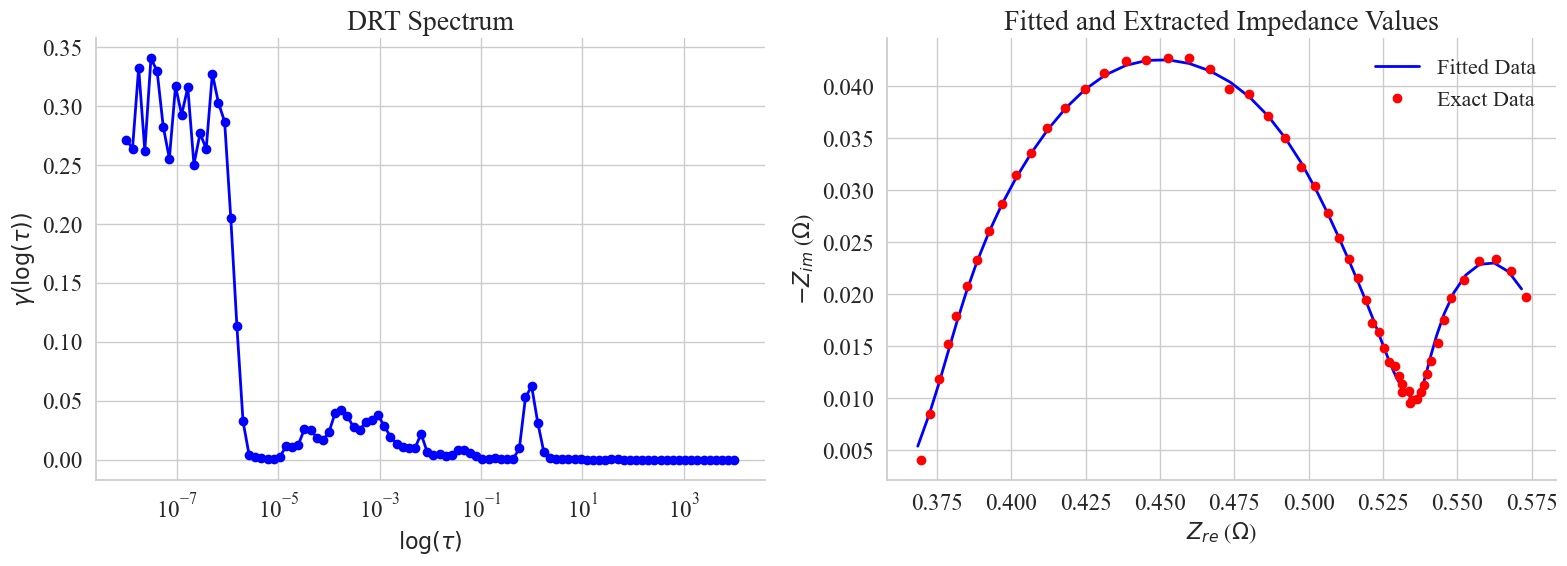

In [15]:
plot = Plot(final_sim, measurement)
plot.show()